# 1. Prior Knowledge

## 1.1 Vanilla RNN
Recurrent Neural Network(RNN)의 기본 수식은 다음과 같은 형태

$
h_t = \tanh(W_h x_t + U_h h_{t-1} + b_h)
$

- $x_t$: 입력 데이터 (시간 스텝 $t$에서)
- $h_t$: 히든 상태 (현재 시점의 기억을 저장하는 벡터)
- $W_h$, $U_h$, $b_h$: 학습 가능한 파라미터

이러한 수식으로 구현된 RNN은 긴 시퀀스를 학습할 때, 기울기가 지나치게 작아지거나 커지는 문제가 발생해,  
이를 해결하기 위해 LSTM과 GRU가 제안됨

## 1.2 LSTM(Long Short-Term Memory)
LSTM은 RNN의 장기 기억 능력을 개선하기 위해 개발되었으며,  
다음의 `4가지 gate를 통해 정볼르 선택적으로 유지하거나 제거`

- Forget gate ($f_t$): 잊어야 할 정보를 결정
- Input gate ($i_t$): 새로 추가할 정보를 결정
- Candidate memory cell ($\tilde{c}_t$): 새로 들어오는 정보를 저장하는 후보
- Output gate ($o_t$): 현재 히든 상태로 출력할 정보를 결정

이를 기반으로 하는 수식은 다음과 같음

$
\begin{aligned}
f_t &= \sigma(W_f [x_t, h_{t-1}] + b_f) \\[5pt]
i_t &= \sigma(W_i [x_t, h_{t-1}] + b_i) \\[5pt]
\tilde{c}_t &= \tanh(W_c [x_t, h_{t-1}] + b_c) \\[5pt]
o_t &= \sigma(W_o [x_t, h_{t-1}] + b_o) \\[5pt]
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \\[5pt]
h_t &= o_t \odot \tanh(c_t)
\end{aligned}
$


- $\sigma$ : sigmoid 함수
- $\odot$ : 요소별 곱셈(element-wise multiplication)

이를 기반으로 구현한 코드는 다음과 같음

In [1]:
import torch
import torch.nn as nn

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.linear_ih = nn.Linear(input_size, 4 * hidden_size)
        self.linear_hh = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, x_t, h_prev, c_prev):
        gates = self.linear_ih(x_t) + self.linear_hh(h_prev)

        i_t, f_t, g_t, o_t = torch.chunk(gates, 4, dim=1)

        i_t = torch.sigmoid(i_t)
        f_t = torch.sigmoid(f_t)
        g_t = torch.tanh(g_t)
        o_t = torch.sigmoid(o_t)

        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t


/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.cell = LSTMCell(input_size, hidden_size)

    def forward(self, x, h0, c0):
        batch_size, seq_len, _ = x.size()
        h, c = h0, c0
        outputs = []

        for t in range(seq_len):
            h, c = self.cell(x[:, t, :], h, c)
            outputs.append(h.unsqueeze(1))

        return torch.cat(outputs, dim=1), (h, c)

In [3]:
torch.manual_seed(42)
device = torch.device('cpu') # 'cuda'로 적용할 경우, torch 내부의 fused kernel을 사용하여 결과값의 차이가 커질 수 있음음

input_size = 3
hidden_size = 4
batch_size = 2
seq_len = 5

x = torch.randn(batch_size, seq_len, input_size).to(device)
h0 = torch.randn(batch_size, hidden_size).to(device)
c0 = torch.randn(batch_size, hidden_size).to(device)

my_lstm = LSTM(input_size, hidden_size).to(device)
torch_lstm = nn.LSTM(input_size, hidden_size, batch_first=True).to(device)

with torch.no_grad():
    torch_lstm.weight_ih_l0.copy_(my_lstm.cell.linear_ih.weight)
    torch_lstm.bias_ih_l0.copy_(my_lstm.cell.linear_ih.bias)
    torch_lstm.weight_hh_l0.copy_(my_lstm.cell.linear_hh.weight)
    torch_lstm.bias_hh_l0.copy_(my_lstm.cell.linear_hh.bias)

out_my, (h_n_my, c_n_my) = my_lstm(x, h0, c0)
out_torch, (h_n_torch, c_n_torch) = torch_lstm(x, (h0.unsqueeze(0), c0.unsqueeze(0)))

print("CPU LSTM Output 차이:", torch.abs(out_my - out_torch).max().item())
print("CPU LSTM hidden 차이:", torch.abs(h_n_my - h_n_torch.squeeze(0)).max().item())
print("CPU LSTM cell 차이:", torch.abs(c_n_my - c_n_torch.squeeze(0)).max().item())

CPU LSTM Output 차이: 5.960464477539063e-08
CPU LSTM hidden 차이: 2.9802322387695312e-08
CPU LSTM cell 차이: 1.1920928955078125e-07


In [4]:
torch.manual_seed(42)
device = torch.device('cuda')

input_size = 3
hidden_size = 4
batch_size = 2
seq_len = 5

x = torch.randn(batch_size, seq_len, input_size).to(device)
h0 = torch.randn(batch_size, hidden_size).to(device)
c0 = torch.randn(batch_size, hidden_size).to(device)

my_lstm = LSTM(input_size, hidden_size).to(device)
torch_lstm = nn.LSTM(input_size, hidden_size, batch_first=True).to(device)

with torch.no_grad():
    torch_lstm.weight_ih_l0.copy_(my_lstm.cell.linear_ih.weight)
    torch_lstm.bias_ih_l0.copy_(my_lstm.cell.linear_ih.bias)
    torch_lstm.weight_hh_l0.copy_(my_lstm.cell.linear_hh.weight)
    torch_lstm.bias_hh_l0.copy_(my_lstm.cell.linear_hh.bias)

out_my, (h_n_my, c_n_my) = my_lstm(x, h0, c0)
out_torch, (h_n_torch, c_n_torch) = torch_lstm(x, (h0.unsqueeze(0), c0.unsqueeze(0)))

print("CPU LSTM Output 차이:", torch.abs(out_my - out_torch).max().item())
print("CPU LSTM hidden 차이:", torch.abs(h_n_my - h_n_torch.squeeze(0)).max().item())
print("CPU LSTM cell 차이:", torch.abs(c_n_my - c_n_torch.squeeze(0)).max().item())

CPU LSTM Output 차이: 7.858872413635254e-05
CPU LSTM hidden 차이: 7.539987564086914e-05
CPU LSTM cell 차이: 0.00010293722152709961


## 1.3 GRU(Gated Recurrent Unit)
GRU는 LSTM보다 구조가 간단하면서도 유사한 성능을 내며, 다음과 같은 두 개의 gate로 구성

- Update gate ($z_t$): 이전 상태를 얼마나 유지할지 결정
- Reset gate ($r_t$): 이전 상태를 얼마나 잊을지 결정

이를 이용한 수식은 다음과 같음

$
\begin{aligned}
z_t &= \sigma(W_z [x_t, h_{t-1}] + b_z) \\[5pt]
r_t &= \sigma(W_r [x_t, h_{t-1}] + b_r) \\[5pt]
\tilde{h}_t &= \tanh(W_h [x_t, r_t \odot h_{t-1}] + b_h) \\[5pt]
h_t &= (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
\end{aligned}
$


위 수식에서,
- $x_t$: 시간 단계 $t$의 입력 벡터
- $h_t$: 시간 단계 $t$의 hidden state 벡터
- $z_t$: update gate (과거 정보를 유지할지 결정)
- $r_t$: reset gate (과거 정보를 잊을지 결정)
- $\sigma$: sigmoid 활성화 함수
- $\odot$: element-wise 곱셈 연산
- $W$, $U$: 학습 가능한 가중치
- $b$: 편향(bias)

이를 이용해 코드로 구현하면 다음과 같음

In [5]:
import torch
import torch.nn as nn

class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # 입력 → 게이트 연산
        self.weight_ih = nn.Parameter(torch.randn(3 * hidden_size, input_size))
        self.bias_ih = nn.Parameter(torch.randn(3 * hidden_size))

        # 히든 → 게이트 연산
        self.weight_hh = nn.Parameter(torch.randn(3 * hidden_size, hidden_size))
        self.bias_hh = nn.Parameter(torch.randn(3 * hidden_size))

    def forward(self, x_t, h_prev):
        gi = torch.nn.functional.linear(x_t, self.weight_ih, self.bias_ih)
        gh = torch.nn.functional.linear(h_prev, self.weight_hh, self.bias_hh)

        i_r, i_z, i_n = gi.chunk(3, dim=1)
        h_r, h_z, h_n = gh.chunk(3, dim=1)

        r_t = torch.sigmoid(i_r + h_r)
        z_t = torch.sigmoid(i_z + h_z)

        # reset gate는 bias를 곱하지 않도록 연산 순서를 명확히 
        n_t = torch.tanh(i_n + r_t * (torch.nn.functional.linear(h_prev, 
                                   self.weight_hh[2*self.hidden_size:], 
                                   self.bias_hh[2*self.hidden_size:])))

        h_t = (1 - z_t) * n_t + z_t * h_prev

        return h_t

In [6]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.cell = GRUCell(input_size, hidden_size)

    def forward(self, x, h0):
        batch_size, seq_len, _ = x.size()
        h = h0
        outputs = []

        for t in range(seq_len):
            h = self.cell(x[:, t, :], h)
            outputs.append(h.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        return outputs, h

In [7]:
torch.manual_seed(42)
device = torch.device('cpu')

input_size = 3
hidden_size = 4
batch_size = 2
seq_len = 5

x = torch.randn(batch_size, seq_len, input_size).to(device)
h0 = torch.randn(batch_size, hidden_size).to(device)

my_gru = GRU(input_size, hidden_size).to(device)
torch_gru = nn.GRU(input_size, hidden_size, batch_first=True).to(device)

# 가중치 복사
with torch.no_grad():
    torch_gru.weight_ih_l0.copy_(my_gru.cell.weight_ih)
    torch_gru.bias_ih_l0.copy_(my_gru.cell.bias_ih)
    torch_gru.weight_hh_l0.copy_(my_gru.cell.weight_hh)
    torch_gru.bias_hh_l0.copy_(my_gru.cell.bias_hh)

out_my, h_n_my = my_gru(x, h0)
out_torch, h_n_torch = torch_gru(x, h0.unsqueeze(0))

print("GRU 전체 Output 차이:", torch.abs(out_my - out_torch).max().item())
print("GRU 마지막 hidden 차이:", torch.abs(h_n_my - h_n_torch.squeeze(0)).max().item())

GRU 전체 Output 차이: 1.4901161193847656e-07
GRU 마지막 hidden 차이: 1.4901161193847656e-07


In [8]:
torch.manual_seed(42)
device = torch.device('cuda')

input_size = 3
hidden_size = 4
batch_size = 2
seq_len = 5

x = torch.randn(batch_size, seq_len, input_size).to(device)
h0 = torch.randn(batch_size, hidden_size).to(device)

my_gru = GRU(input_size, hidden_size).to(device)
torch_gru = nn.GRU(input_size, hidden_size, batch_first=True).to(device)

# 가중치 복사
with torch.no_grad():
    torch_gru.weight_ih_l0.copy_(my_gru.cell.weight_ih)
    torch_gru.bias_ih_l0.copy_(my_gru.cell.bias_ih)
    torch_gru.weight_hh_l0.copy_(my_gru.cell.weight_hh)
    torch_gru.bias_hh_l0.copy_(my_gru.cell.bias_hh)

out_my, h_n_my = my_gru(x, h0)
out_torch, h_n_torch = torch_gru(x, h0.unsqueeze(0))

print("GRU 전체 Output 차이:", torch.abs(out_my - out_torch).max().item())
print("GRU 마지막 hidden 차이:", torch.abs(h_n_my - h_n_torch.squeeze(0)).max().item())

GRU 전체 Output 차이: 0.0007819235324859619
GRU 마지막 hidden 차이: 0.0006472766399383545


# 2. Minimalize GRU

## 2.1 이전 상태 $h_{t-1}$ 의존 제거

Minimalization을 위한 첫 번째 단계는 Mamba에서 적용된 방식과 같이 병렬 처리를 가능하도록 함으로써 하드웨어 자원을 최대한 활용해 연산 효율성을 높이는 것으로, 이전 상태($h_{t-1}$)을 제거

### 기존 구조
- $z_t$, $r_t$, $\tilde{h}_t$ 모두 $h_{t-1}$에 의존 → 병렬화 불가능

### 변경 구조
- $z_t = \sigma(W_z x_t)$
- $r_t = \text{(삭제)}$
- $\tilde{h}_t = W_h x_t$

## 2.2 비선형 함수 $\tanh$ 제거

$\tanh$는 출력값을 $(-1, 1)$로 제한하는 활성화 함수로,  
이를 제거하면 표현력은 약간 줄지만, 선형 처리 및 병렬화가 더 쉬워짐

(왜????)

$
\tilde{h}_t = W_h x_t \quad (\text{선형 처리})
$

## 2.3 최종 minGRU 구조 도출

현재까지의 최종적인 수식은 다음과 같음

$
\begin{aligned}
z_t &= \sigma(W_z x_t) \\
\tilde{h}_t &= W_h x_t \\
h_t &= (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
\end{aligned}
$

위 구조는 다음과 같은 장점을 지니고 있음
- 파라미터 수가 **3개 → 2개**로 줄어들고, 연산량도 줄어듦
- 단일 입력만으로 상태 갱신 가능 → 병렬화 가능성 확보

## 2.4 minGRU를 병렬 구조로 해석하기 (Prefix-Scan 구조)

위까지의 수식을 아래와 같이 단순화

$
h_t = a_t \odot h_{t-1} + b_t \quad \\ 
\text{where} \quad a_t = 1 - z_t,\quad b_t = z_t \odot \tilde{h}_t
$

위 수식은 정확히 **선형 recurrence 형태**이며, 아래와 같은 누적 합 형태의 scan 구조로 근사 가능

$
h_t = \sum_{k=0}^{t} \left( b_k \prod_{j=k+1}^{t} a_j \right)
$


위 구조는 병렬 Blelloch scan과 같은 scan 알고리즘을 통해 $\mathcal{O}(\log T)$ 병렬 처리가 가능

### minGRU의 전체 수식

$
\begin{aligned}
z_t &= \sigma(W_z x_t) \\[4pt]
\tilde{h}_t &= W_h x_t \\[4pt]
a_t &= 1 - z_t \\[4pt]
b_t &= z_t \odot \tilde{h}_t \\[4pt]
h_t &= a_t \odot h_{t-1} + b_t
\end{aligned}
$

## 2.5 코드

### 2.5.1 Overal Structure(Simple)

In [9]:
import torch
import torch.nn as nn

class MinGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.z_proj = nn.Linear(input_size, hidden_size, bias=True)
        self.h_proj = nn.Linear(input_size, hidden_size, bias=True)

    def forward(self, x_t, h_prev):
        z_t = torch.sigmoid(self.z_proj(x_t))              # update gate
        h_tilde = self.h_proj(x_t)                         # candidate hidden
        a_t = 1.0 - z_t
        b_t = z_t * h_tilde
        h_t = a_t * h_prev + b_t
        return h_t


In [10]:
class MinGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.cell = MinGRUCell(input_size, hidden_size)

    def forward(self, x, h0):
        # x: [B, T, input_size]
        batch_size, seq_len, _ = x.size()
        h = h0
        outputs = []

        for t in range(seq_len):
            h = self.cell(x[:, t, :], h)
            outputs.append(h.unsqueeze(1))

        return torch.cat(outputs, dim=1), h


In [11]:
# 실험 설정
input_size = 3
hidden_size = 5
batch_size = 2
seq_len = 4

torch.manual_seed(0)

# 입력 데이터 생성
x = torch.randn(batch_size, seq_len, input_size)
h0 = torch.zeros(batch_size, hidden_size)

# minGRU 모델 실행
min_gru = MinGRU(input_size, hidden_size)
out_seq, h_last = min_gru(x, h0)

print("입력 시퀀스 크기:", x.shape)
print("출력 시퀀스 크기:", out_seq.shape)
print("최종 hidden 상태:", h_last.shape)
print("출력 예시:", out_seq[0])


입력 시퀀스 크기: torch.Size([2, 4, 3])
출력 시퀀스 크기: torch.Size([2, 4, 5])
최종 hidden 상태: torch.Size([2, 5])
출력 예시: tensor([[ 0.0162, -0.3345, -0.1807, -0.0015, -0.4170],
        [ 0.1418, -0.0706, -0.1691, -0.4127, -0.0728],
        [-0.0705, -0.4927, -0.2593, -0.0867, -0.5415],
        [ 0.1813, -0.1056, -0.2391, -0.4562, -0.0858]],
       grad_fn=<SelectBackward0>)


### 2.5.2 prefix-scan (not parallel yet, just logic)

Mamba에서와 동일하게 torch로는 병렬 스캔이 어려워,  
일단 순차적인 방식으로 구현해 수치적인 차이가 없는지 확인

In [12]:
def prefix_scan_min_gru(a_seq, b_seq, h0):
    """
    시뮬레이션용 prefix-scan 방식의 minGRU
    - a_seq: [B, T, H], 곱해지는 계수 (1 - z)
    - b_seq: [B, T, H], 가중합 (z * h_tilde)
    - h0:    [B, H], 초기 hidden
    """
    B, T, H = a_seq.shape
    h = h0
    outputs = []

    for t in range(T):
        h = a_seq[:, t] * h + b_seq[:, t]
        outputs.append(h.unsqueeze(1))

    return torch.cat(outputs, dim=1)

### 2.5.3 ADD prefix-scan TO minGRU

In [13]:
class MinGRU_w_SCAN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.z_proj = nn.Linear(input_size, hidden_size)
        self.h_proj = nn.Linear(input_size, hidden_size)

    def forward(self, x, h0):
        # x: [B, T, input_size]
        z = torch.sigmoid(self.z_proj(x))            # [B,T,H]
        h_tilde = self.h_proj(x)                     # [B,T,H]
        a = 1 - z
        b = z * h_tilde
        return prefix_scan_min_gru(a, b, h0)


### 2.5.4 Test

In [14]:
input_size = 3
hidden_size = 5
batch_size = 2
seq_len = 6

x = torch.randn(batch_size, seq_len, input_size)
h0 = torch.zeros(batch_size, hidden_size)

# 순차 구현
min_gru_seq = MinGRU(input_size, hidden_size)
out_seq, _ = min_gru_seq(x, h0)

# 병렬 구현
min_gru_par = MinGRU_w_SCAN(input_size, hidden_size)

# 동일 weight 복사
min_gru_par.z_proj.load_state_dict(min_gru_seq.cell.z_proj.state_dict())
min_gru_par.h_proj.load_state_dict(min_gru_seq.cell.h_proj.state_dict())
out_par = min_gru_par(x, h0)

# 비교
max_diff = torch.abs(out_seq - out_par).max().item()
print(f"순차 vs 병렬 minGRU 출력 차이: {max_diff:.6f}")

순차 vs 병렬 minGRU 출력 차이: 0.000000


## 3. Performance Test (Single Layer & Simple Structure)

## 3.1 Construct Small Dataset

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 데이터 로드 및 정규화
data = load_wine()
X, y = data.data, data.target
X = StandardScaler().fit_transform(X)  # 표준화
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (N, 13, 1)
y = torch.tensor(y, dtype=torch.long)

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16)


## 3.2 GRU Classifier (Manual)

In [16]:
class ManualGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.linear_ih = nn.Linear(input_size, 3 * hidden_size)
        self.linear_hh = nn.Linear(hidden_size, 3 * hidden_size)

    def forward(self, x_t, h_prev):
        i_r, i_z, i_n = self.linear_ih(x_t).chunk(3, dim=1)
        h_r, h_z, h_n = self.linear_hh(h_prev).chunk(3, dim=1)

        r_t = torch.sigmoid(i_r + h_r)
        z_t = torch.sigmoid(i_z + h_z)
        n_t = torch.tanh(i_n + r_t * h_n)
        h_t = (1 - z_t) * n_t + z_t * h_prev
        return h_t

class ManualGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.cell = ManualGRUCell(input_size, hidden_size)

    def forward(self, x, h0):
        h = h0
        outs = []
        for t in range(x.size(1)):
            h = self.cell(x[:, t], h)
            outs.append(h.unsqueeze(1))
        return torch.cat(outs, dim=1), h

class ManualGRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.gru = ManualGRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(x.size(0), self.fc.in_features, device=x.device)
        h_seq, _ = self.gru(x, h0)
        return self.fc(h_seq[:, -1])


## 3.3 GRU Classifier(Torch Official)

In [17]:
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, h_n = self.gru(x)
        return self.fc(h_n[-1])

## 3.4 minGRU Classifier (not parallel yet)

In [18]:
class MinGRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.gru = MinGRU_w_SCAN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(x.size(0), self.gru.h_proj.out_features, device=x.device)
        h_seq = self.gru(x, h0)
        return self.fc(h_seq[:, -1])


## 3.5 Train & Validation

In [19]:
import time

def train_and_eval(model, train_loader, test_loader, epochs=50, lr=1e-2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    opt = optim.AdamW(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    hist = {"train_acc": [], "test_acc": [], "train_loss": [], "test_loss": []}

    for ep in range(epochs):
        t0 = time.time()
        model.train()
        correct = total = 0
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            pred = model(xb)
            loss = crit(pred, yb)
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)
            correct += (pred.argmax(1) == yb).sum().item()
            total += yb.size(0)
        hist["train_acc"].append(correct / total)
        hist["train_loss"].append(total_loss / total)

        model.eval()
        correct = total = 0
        total_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = crit(pred, yb)
                total_loss += loss.item() * xb.size(0)
                correct += (pred.argmax(1) == yb).sum().item()
                total += yb.size(0)
        hist["test_acc"].append(correct / total)
        hist["test_loss"].append(total_loss / total)

        print(f"[Epoch {ep+1:02d}] Train Acc: {hist['train_acc'][-1]*100:.2f}% | "
              f"Test Acc: {hist['test_acc'][-1]*100:.2f}% | Time: {time.time()-t0:.2f}s")

    return hist

In [20]:
def plot_history(histories):
    plt.figure(figsize=(10,6))
    for name, h in histories.items():
        plt.plot(h["train_acc"], linestyle="--", label=f"{name} Train Acc")
        plt.plot(h["test_acc"], linestyle="-", label=f"{name} Test Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title("Train / Test Accuracy per Epoch")
    plt.legend(); plt.grid(True)
    plt.show()

    plt.figure(figsize=(10,6))
    for name, h in histories.items():
        plt.plot(h["train_loss"], linestyle="-", label=f"{name} Train Loss")
        plt.plot(h["test_loss"], linestyle="--", label=f"{name} Test Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("Train / Test Loss per Epoch")
    plt.legend(); plt.grid(True)
    plt.show()

In [21]:
def print_model_structure(model, name):
    print(f"\n>>> {name} 모델 구조:")
    print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters())}")
    print(f"모델 구조: {model}")
    print(f"모델 장치: {next(model.parameters()).device}")


>>> MyGRU 모델 구조:
모델 파라미터 수: 291
모델 구조: ManualGRUClassifier(
  (gru): ManualGRU(
    (cell): ManualGRUCell(
      (linear_ih): Linear(in_features=1, out_features=24, bias=True)
      (linear_hh): Linear(in_features=8, out_features=24, bias=True)
    )
  )
  (fc): Linear(in_features=8, out_features=3, bias=True)
)
모델 장치: cpu

>>> MyGRU 학습 시작
[Epoch 01] Train Acc: 39.44% | Test Acc: 63.89% | Time: 0.24s
[Epoch 02] Train Acc: 70.42% | Test Acc: 91.67% | Time: 0.13s
[Epoch 03] Train Acc: 88.03% | Test Acc: 91.67% | Time: 0.13s
[Epoch 04] Train Acc: 85.92% | Test Acc: 88.89% | Time: 0.13s
[Epoch 05] Train Acc: 90.14% | Test Acc: 94.44% | Time: 0.13s
[Epoch 06] Train Acc: 91.55% | Test Acc: 97.22% | Time: 0.13s
[Epoch 07] Train Acc: 92.96% | Test Acc: 97.22% | Time: 0.13s
[Epoch 08] Train Acc: 93.66% | Test Acc: 94.44% | Time: 0.13s
[Epoch 09] Train Acc: 95.07% | Test Acc: 97.22% | Time: 0.13s
[Epoch 10] Train Acc: 94.37% | Test Acc: 97.22% | Time: 0.13s
[Epoch 11] Train Acc: 97.18% | Test A

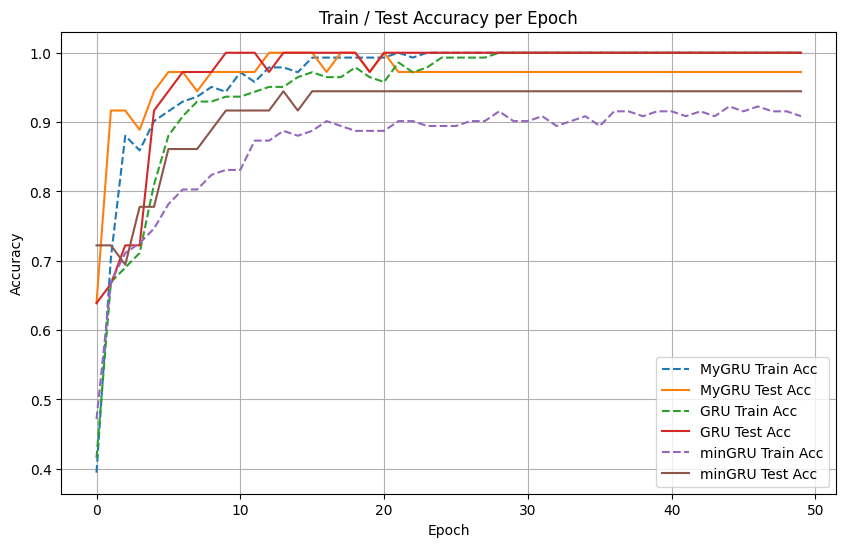

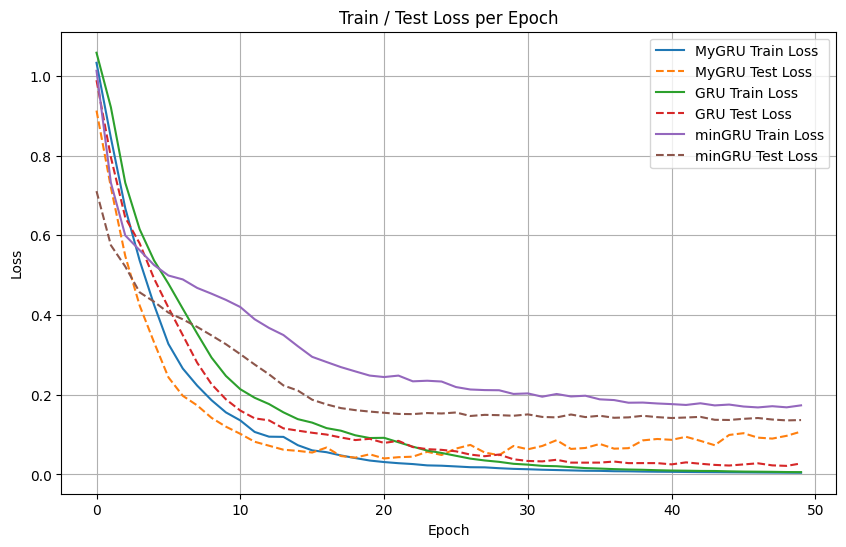

In [22]:
# 정의
input_size = 1
hidden_size1 = 8
hidden_size2 = 32
num_classes = 3

models = {
    "MyGRU": ManualGRUClassifier(input_size, hidden_size1, num_classes),
    "GRU": GRUClassifier(input_size, hidden_size1, num_classes),
    "minGRU": MinGRUClassifier(input_size, hidden_size2, num_classes),
}

histories = {}

# 실행
for name, model in models.items():
    print_model_structure(model, name)
    print(f"\n>>> {name} 학습 시작")
    hist = train_and_eval(model, train_loader, test_loader)
    histories[name] = hist

# 시각화
plot_history(histories)


# 4. Minimalize LSTM

Minimalize하는 과정(원리)는 GRU와 같으며, 이전에 살펴봤던 LSTM의 최종 수식은 다음과 같았음

$
\begin{aligned}
f_t &= \sigma(W_f [x_t, h_{t-1}] + b_f) \\[4pt]
i_t &= \sigma(W_i [x_t, h_{t-1}] + b_i) \\[4pt]
\tilde{c}_t &= \tanh(W_c [x_t, h_{t-1}] + b_c) \\[4pt]
o_t &= \sigma(W_o [x_t, h_{t-1}] + b_o) \\[4pt]
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \\[4pt]
h_t &= o_t \odot \tanh(c_t)
\end{aligned}
$

## 4.1 $h_{t-1}$ 의존성 제거

병렬화를 위해 이전 상태에 대한 의존성을 제거함으로써 현재의 입력 $x_{t}$에만 의존하도록 변경

$
\begin{aligned}
f_t &= \sigma(W_f x_t), \\
i_t &= \sigma(W_i x_t), \\
\tilde{c}_t &= \tanh(W_c x_t), \\
o_t &= \sigma(W_o x_t)
\end{aligned}
$

*단, 이후 minLSTM에서는 $o_t$ 게이트도 제거됩니다.


## 4.2 $\tanh$ 제거

$\tilde{c}_t$에 적용되던 비선형 함수 $\tanh$를 제거해, 약간의 표현력 감소를 감수하고 선형 처리 및 병렬화에 용이하도록 변경

$
\tilde{c}_t = W_c x_t \quad (\text{선형})
$

## 4.3 게이트 정규화 - Softmax-like

$f_t$와 $i_t$는 softmax처럼 정규화된 가중치로 해석되며 다음과 같이 변경

$
f'_t = \frac{f_t}{f_t + i_t}, \quad
i'_t = \frac{i_t}{f_t + i_t}
$

위 수식을 고려해 최종적으로 다음과 같이 간소화할 수 있음

$
\begin{aligned}
f_t &= \sigma(W_f x_t), \\
i_t &= \sigma(W_i x_t), \\
\tilde{c}_t &= W_c x_t, \\
f'_t &= \frac{f_t}{f_t + i_t}, \\
i'_t &= \frac{i_t}{f_t + i_t}, \\
h_t &= f'_t \odot h_{t-1} + i'_t \odot \tilde{c}_t
\end{aligned}
$

## 4.4 코드 구현

In [23]:
class MinLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.f_proj = nn.Linear(input_size, hidden_size)
        self.i_proj = nn.Linear(input_size, hidden_size)
        self.c_proj = nn.Linear(input_size, hidden_size)

    def forward(self, x_t, h_prev):
        f_t = torch.sigmoid(self.f_proj(x_t))
        i_t = torch.sigmoid(self.i_proj(x_t))
        denom = f_t + i_t + 1e-6 # 작은 값 추가
        f_hat = f_t / denom
        i_hat = i_t / denom
        c_tilde = self.c_proj(x_t)
        h_t = f_hat * h_prev + i_hat * c_tilde
        return h_t

In [24]:
class MinLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.cell = MinLSTMCell(input_size, hidden_size)

    def forward(self, x, h0):
        h = h0
        outputs = []
        for t in range(x.size(1)):
            h = self.cell(x[:, t], h)
            outputs.append(h.unsqueeze(1))
        return torch.cat(outputs, dim=1), h

## 4.5 Performance Test

### 4.5.1 Manual LSTM Classifier

In [25]:
class ManualLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.rnn = LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        B = x.size(0)
        h0 = torch.zeros(B, self.fc.in_features, device=x.device)
        c0 = torch.zeros(B, self.fc.in_features, device=x.device)
        h_seq, _ = self.rnn(x, h0, c0)
        return self.fc(h_seq[:, -1])

### 4.5.2 Official LSTM Classifier

In [26]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n[-1])


### 4.5.3 minLSTM Classifier

In [27]:
class MinLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.rnn = MinLSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(x.size(0), self.fc.in_features, device=x.device)
        h_seq, _ = self.rnn(x, h0)
        return self.fc(h_seq[:, -1])


>>> ManualLSTM 모델 구조:
모델 파라미터 수: 379
모델 구조: ManualLSTMClassifier(
  (rnn): LSTM(
    (cell): LSTMCell(
      (linear_ih): Linear(in_features=1, out_features=32, bias=True)
      (linear_hh): Linear(in_features=8, out_features=32, bias=True)
    )
  )
  (fc): Linear(in_features=8, out_features=3, bias=True)
)
모델 장치: cpu

>>> ManualLSTM 학습 시작
[Epoch 01] Train Acc: 61.97% | Test Acc: 69.44% | Time: 0.11s
[Epoch 02] Train Acc: 68.31% | Test Acc: 66.67% | Time: 0.12s
[Epoch 03] Train Acc: 67.61% | Test Acc: 69.44% | Time: 0.11s
[Epoch 04] Train Acc: 70.42% | Test Acc: 69.44% | Time: 0.11s
[Epoch 05] Train Acc: 70.42% | Test Acc: 86.11% | Time: 0.12s
[Epoch 06] Train Acc: 88.73% | Test Acc: 97.22% | Time: 0.11s
[Epoch 07] Train Acc: 92.25% | Test Acc: 97.22% | Time: 0.11s
[Epoch 08] Train Acc: 92.25% | Test Acc: 97.22% | Time: 0.11s
[Epoch 09] Train Acc: 92.96% | Test Acc: 94.44% | Time: 0.11s
[Epoch 10] Train Acc: 95.07% | Test Acc: 97.22% | Time: 0.11s
[Epoch 11] Train Acc: 97.18% | Test 

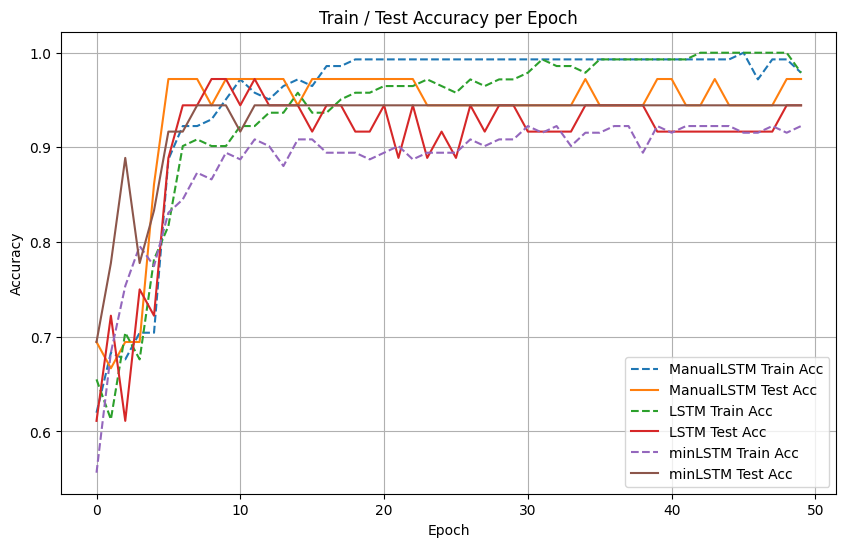

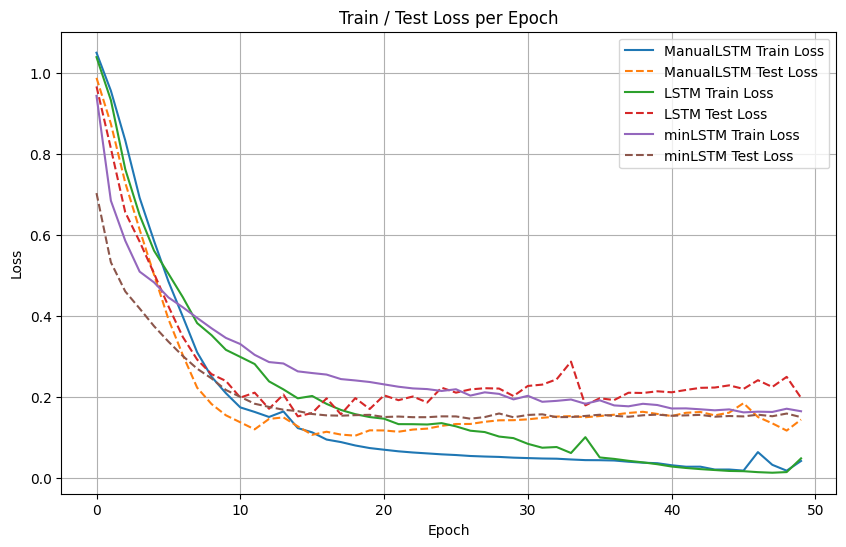

In [28]:
# 모델 초기화
input_size = 1
hidden_size1 = 8
hidden_size2 = 32
num_classes = 3

models = {
    "ManualLSTM": ManualLSTMClassifier(input_size, hidden_size1, num_classes),
    "LSTM": LSTMClassifier(input_size, hidden_size1, num_classes),
    "minLSTM": MinLSTMClassifier(input_size, hidden_size2, num_classes),
}

# 학습 기록 저장
histories = {}
for name, model in models.items():
    print_model_structure(model, name)
    print(f"\n>>> {name} 학습 시작")
    hist = train_and_eval(model, train_loader, test_loader)
    histories[name] = hist
# 시각화
plot_history(histories)

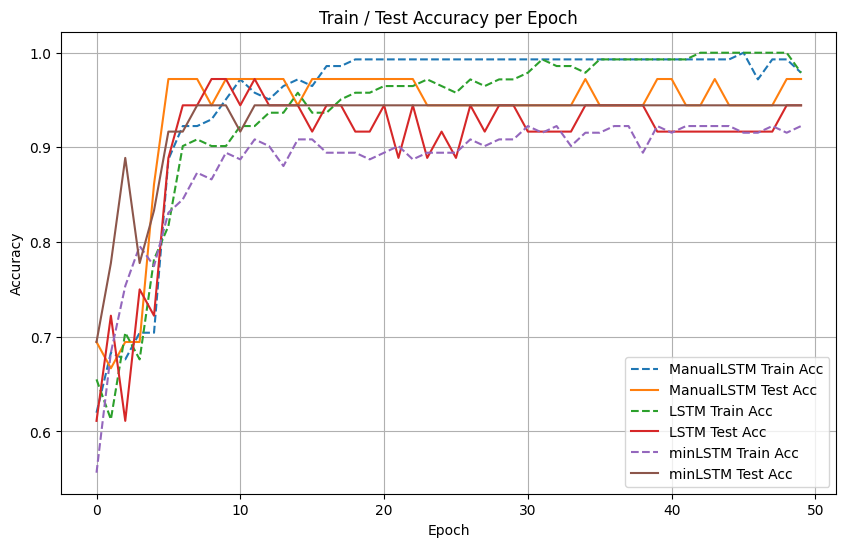

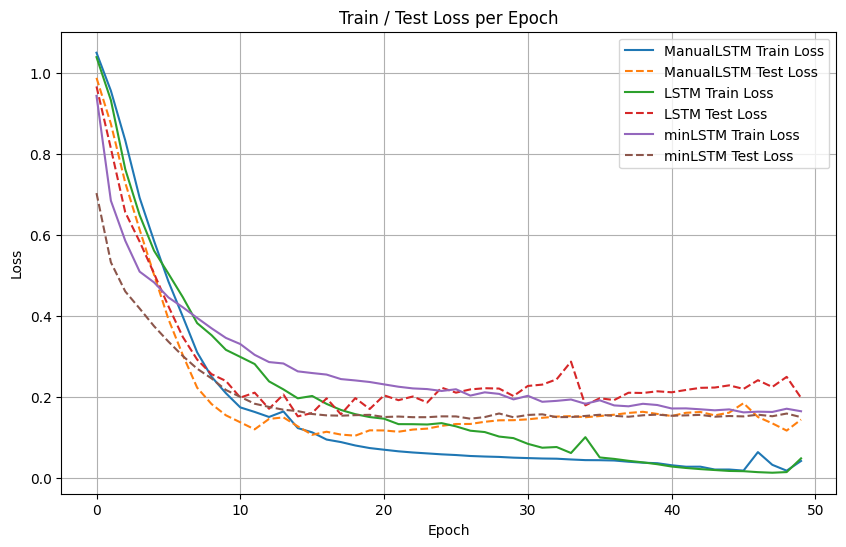

In [29]:
# 시각화
plot_history(histories)